# MFIN7034 Problem Set 1 – Factor Model
In this problem set, you will run regressions to understand how factor models work in (cross-sectional and time-series) asset return analysis.

Data sources:
1. https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html#Research
2. https://global-q.org/factors.html
3. https://finance.wharton.upenn.edu/~stambaug/

To match the datasets for stock returns, use monthly versions with time range from 2000-01 to 2022-12 for all factor datasets. \
Submission: Proper visualization and clear interpretations & discussions, such as explaining why the coefficient of a factor change over time, will also be graded.

## Understand dataset and preprocessing

In [82]:
import pandas as pd
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # multiple output per jupyter notebook code block

In [14]:
# loading data

# manual modification: 
# 1. delete 'Annual Factors' at the end of 'F-F_Research_Data_5_Factors_2x3.csv'
# 2. remove header comment '%' in liq_data_1962_2023.txt
return_df = pd.read_csv('data/monthly_stock_returns.csv')
ff5_df = pd.read_csv('data/F-F_Research_Data_5_Factors_2x3.csv', comment='%')
q5_df = pd.read_csv('data/q5_factors_monthly_2023.csv')

# special handling
liq_df = pd.read_csv(
    'data/liq_data_1962_2023.txt',
    sep='\t',            # Split on one or more tabs
    comment='%',         # Skip lines starting with '%'
    header=0,            # Use the first non-comment line as header
    skipinitialspace=True,  # Ignore spaces after tabs
    na_values=-99,       # Treat -99 as missing values
    usecols=[0, 1, 2, 3] # explicityly select 4 columns
)

In [7]:
return_df.head()
ff5_df.head()
q5_df.head()
liq_df.head()

,PERMNO,YYYYMM,MthPrc,MthRet
0,10324,200001,52.0000,0.155556
1,10324,200002,57.4375,0.104567
2,10324,200003,50.1250,-0.127312
3,10324,200004,48.8125,-0.026185
4,10324,200005,56.8125,0.163892


,Unnamed: 0,Mkt-RF,SMB,HML,RMW,CMA,RF
0,196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1,196308,5.07,-0.80,1.80,0.36,-0.35,0.25
2,196309,-1.57,-0.52,0.13,-0.71,0.29,0.27
3,196310,2.53,-1.39,-0.10,2.80,-2.01,0.29
4,196311,-0.85,-0.88,1.75,-0.51,2.24,0.27


,year,month,R_F,R_MKT,R_ME,R_IA,R_ROE,R_EG
0,1967,1,0.3927,8.1852,6.8122,-2.9263,1.8813,-2.5511
1,1967,2,0.3743,0.7557,1.6235,-0.2915,3.5399,2.1792
2,1967,3,0.3693,4.0169,1.9836,-1.6772,1.8417,-1.1192
3,1967,4,0.3344,3.8786,-0.6700,-2.8972,1.0253,-1.6371
4,1967,5,0.3126,-4.2807,2.7366,2.1864,0.6038,0.1191


,Month,Agg Liq.,Innov Liq (eq8),Traded Liq (LIQ_V)
0,196208,-0.017537,0.004260,NaN
1,196209,-0.004075,0.011757,NaN
2,196210,-0.104212,-0.074128,NaN
3,196211,-0.019742,0.028572,NaN
4,196212,-0.005089,0.013037,NaN


Organise timestamp column, same format for all dataframes (pandas datetime object), monthly from 2000-01 to 2022-12

In [15]:
return_df['Month'] = pd.to_datetime(return_df['YYYYMM'], format='%Y%m')
return_df.drop(columns=['YYYYMM'], inplace=True)

In [16]:
ff5_df['Month'] = pd.to_datetime(ff5_df.iloc[:, 0], format='%Y%m')
ff5_df.drop(ff5_df.columns[0], axis=1, inplace=True)

In [29]:
q5_df['Month'] = pd.to_datetime(
    q5_df['year'].astype(str) + '-' + q5_df['month'].astype(str).str.zfill(2), # zfill(2): '1' -> '01', padding
    format="%Y-%m"
)
q5_df.drop(columns=['year', 'month'], inplace=True)

In [32]:
liq_df['Month'] = pd.to_datetime(liq_df['Month'], format='%Y%m')

In [34]:
return_df.head()
ff5_df.head()
q5_df.head()
liq_df.head()

,PERMNO,MthPrc,MthRet,Month
0,10324,52.0000,0.155556,2000-01-01
1,10324,57.4375,0.104567,2000-02-01
2,10324,50.1250,-0.127312,2000-03-01
3,10324,48.8125,-0.026185,2000-04-01
4,10324,56.8125,0.163892,2000-05-01


,Mkt-RF,SMB,HML,RMW,CMA,RF,Month
0,-0.39,-0.41,-0.97,0.68,-1.18,0.27,1963-07-01
1,5.07,-0.80,1.80,0.36,-0.35,0.25,1963-08-01
2,-1.57,-0.52,0.13,-0.71,0.29,0.27,1963-09-01
3,2.53,-1.39,-0.10,2.80,-2.01,0.29,1963-10-01
4,-0.85,-0.88,1.75,-0.51,2.24,0.27,1963-11-01


,R_F,R_MKT,R_ME,R_IA,R_ROE,R_EG,Month
0,0.3927,8.1852,6.8122,-2.9263,1.8813,-2.5511,1967-01-01
1,0.3743,0.7557,1.6235,-0.2915,3.5399,2.1792,1967-02-01
2,0.3693,4.0169,1.9836,-1.6772,1.8417,-1.1192,1967-03-01
3,0.3344,3.8786,-0.6700,-2.8972,1.0253,-1.6371,1967-04-01
4,0.3126,-4.2807,2.7366,2.1864,0.6038,0.1191,1967-05-01


,Month,Agg Liq.,Innov Liq (eq8),Traded Liq (LIQ_V)
0,1962-08-01,-0.017537,0.004260,NaN
1,1962-09-01,-0.004075,0.011757,NaN
2,1962-10-01,-0.104212,-0.074128,NaN
3,1962-11-01,-0.019742,0.028572,NaN
4,1962-12-01,-0.005089,0.013037,NaN


## Task 1: Factor Regression (Naive)
For each stock, each month, use the data from 60 months ago (including the current month) to the previous month (it is okay if the sample has less than 60 months as long as it can be estimated in OLS), and run regression (“rolling-window regression”). Both FF5 and HXZ5 contain market returns, use the market return in FF5 - "Mkt-RF".

In [ ]:
# TODO: R_i,t, should it be excess return?

In [43]:
# merging data
factor_reg_df = pd.merge(return_df, ff5_df, how='left', on='Month')
factor_reg_df = pd.merge(factor_reg_df, q5_df, how='left', on='Month')

# Both FF5 and HXZ5 contain market returns, use the market return in FF5 - "Mkt-RF"
# TODO: drop R_F risk free?
factor_reg_df.drop(columns=['R_MKT', 'R_F', 'RF'], inplace=True)

In [81]:
window_size = 60 # 5 years rolling window
stock_ids = return_df['PERMNO'].unique()
factor_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'R_ME', 'R_IA', 'R_ROE', 'R_EG']
result_df = pd.DataFrame(columns=['PERMNO', 'Month', 'const'] + factor_names)

# TODO: run regression for all stocks, add another layer of iteration
temp_id = 10324
temp_df = factor_reg_df[factor_reg_df['PERMNO'] == temp_id]

for i in range(window_size, len(temp_df)):
  # data until previous month
  window_df = temp_df.iloc[i-window_size: i]
  curr_month = temp_df['Month'][i]

  # running regression
  X = sm.add_constant(window_df[factor_names])
  y = window_df['MthRet']
  model = sm.OLS(y, X).fit()
  
  # create result row
  res_row = {
    'PERMNO': temp_id,
    'Month': curr_month,
    **dict(zip(['const'] + factor_names, model.params))
  }
  result_df = pd.concat([result_df, pd.DataFrame([res_row])], ignore_index=True)

result_df

/var/folders/40/m24m56td08b_d5vqj9mv7ty40000gn/T/ipykernel_20130/4143546300.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame([res_row])], ignore_index=True)


,PERMNO,Month,const,Mkt-RF,SMB,HML,RMW,CMA,R_ME,R_IA,R_ROE,R_EG
0,10324,2005-01-01,0.019023,0.007996,-0.000502,0.004369,-0.017306,-0.008905,-0.000893,0.002178,-0.004074,0.032710
1,10324,2005-02-01,0.015484,0.010151,0.008488,0.006640,-0.018981,-0.009887,-0.008589,0.000570,-0.000583,0.034372
2,10324,2005-03-01,0.020194,0.007936,-0.008579,0.005492,-0.022334,-0.004930,0.008518,-0.006696,-0.002187,0.037713
3,10324,2005-04-01,0.020701,0.010678,-0.009214,0.006225,-0.019056,-0.013685,0.007673,0.001838,-0.002864,0.037451
4,10324,2005-05-01,0.018890,0.011025,-0.009314,0.005834,-0.018285,-0.014973,0.008411,0.003660,-0.003058,0.037093
...,...,...,...,...,...,...,...,...,...,...,...,...
71,10324,2010-12-01,0.003089,0.003920,-0.031272,-0.001903,-0.004308,0.014145,0.028008,-0.003810,0.002754,-0.003220
72,10324,2011-01-01,0.002527,0.003841,-0.033148,-0.001909,-0.003083,0.013072,0.030119,-0.003671,0.002669,-0.002903
73,10324,2011-02-01,0.002261,0.003829,-0.033129,-0.001883,-0.003049,0.013552,0.030476,-0.004360,0.002583,-0.002498
74,10324,2011-03-01,0.003780,0.003707,-0.032803,-0.002245,-0.003741,0.012703,0.029842,-0.002428,0.002668,-0.003277


<Figure size 1400x600 with 0 Axes>

Text(0.5, 1.0, 'Alpha and Market RF - PERMNO 10324')

Text(0, 0.5, 'Percentage')

(array([12418., 12784., 13149., 13514., 13879., 14245., 14610., 14975.]),
 [Text(12418.0, 0, '2004'),
  Text(12784.0, 0, '2005'),
  Text(13149.0, 0, '2006'),
  Text(13514.0, 0, '2007'),
  Text(13879.0, 0, '2008'),
  Text(14245.0, 0, '2009'),
  Text(14610.0, 0, '2010'),
  Text(14975.0, 0, '2011')])

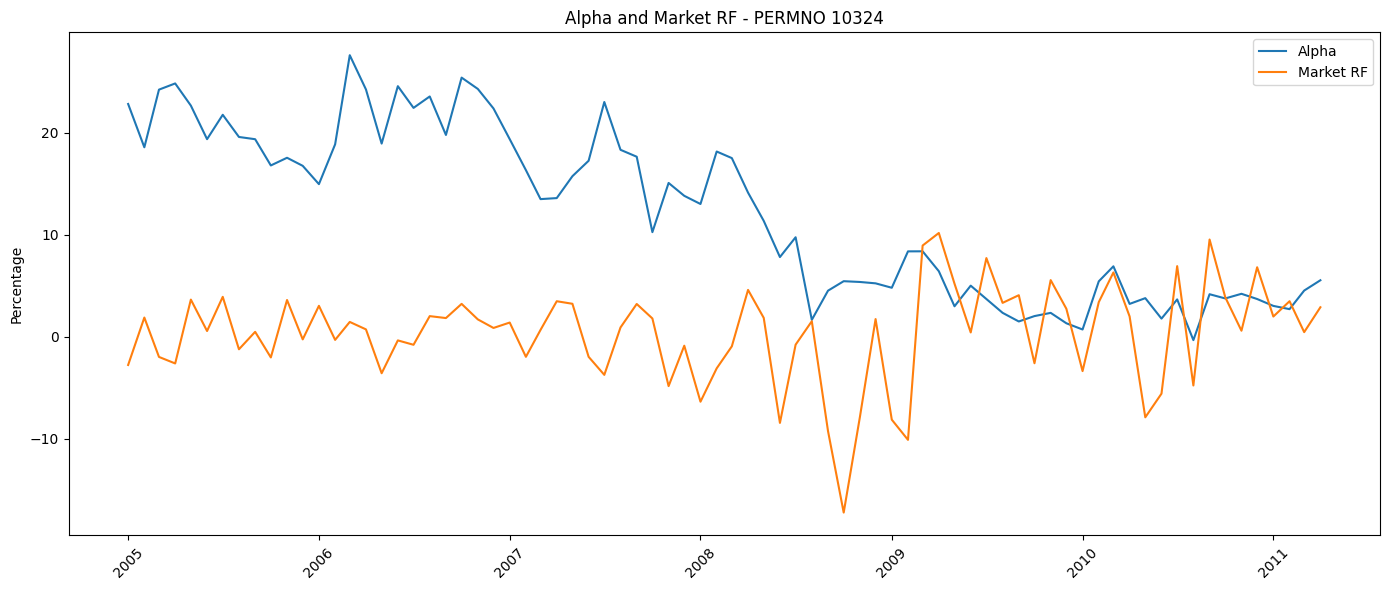

In [94]:
# plot
alpha_df = result_df[result_df['PERMNO'] == 10324][['Month', 'const']]

# in percent, and annualise (?)
alpha_df['const'] = alpha_df['const'] * 100 * 12
plot_df = pd.merge(
  alpha_df,
  ff5_df[['Month', 'Mkt-RF']],
  on='Month',
  how='inner'
)

plt.figure(figsize=(14, 6))
plt.plot(plot_df['Month'], plot_df['const'], label='Alpha')
plt.plot(plot_df['Month'], plot_df['Mkt-RF'], label='Market RF')
plt.title('Alpha and Market RF - PERMNO 10324')
plt.ylabel('Percentage')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Task 2: Fama-MacBeth Regression

## Task 3: LASSO Regression